## NYUD+KITTI- joint semantic segmentation and depth estimation on both datasets with a single network

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

In [2]:
import sys
sys.path.append('../')
from models import net

In [3]:
import cv2

In [4]:
import torch
from torch.autograd import Variable

In [5]:
# Pre-processing and post-processing constants #
CMAP_NYUD = np.load('../cmap_nyud.npy')
CMAP_KITTI = np.load('../cmap_kitti.npy')
DEPTH_COEFF_NYUD = 5000. # to convert into metres
DEPTH_COEFF_KITTI = 800.
HAS_CUDA = torch.cuda.is_available()
IMG_SCALE  = 1./255
IMG_MEAN = np.array([0.485, 0.456, 0.406]).reshape((1, 1, 3))
IMG_STD = np.array([0.229, 0.224, 0.225]).reshape((1, 1, 3))
MAX_DEPTH_NYUD = 8.
MIN_DEPTH_NYUD = 0.
MAX_DEPTH_KITTI = 80.
MIN_DEPTH_KITTI = 0.
NUM_CLASSES = 46
NUM_CLASSES_NYUD = 40
NUM_CLASSES_KITTI = 6
NUM_TASKS = 2 # segm + depth

In [6]:
def prepare_img(img):
    return (img * IMG_SCALE - IMG_MEAN) / IMG_STD

In [7]:
model = net(num_classes=NUM_CLASSES, num_tasks=NUM_TASKS)
if HAS_CUDA:
    _ = model.cuda()
_ = model.eval()

In [8]:
ckpt = torch.load('../../weights/ExpNYUDKITTI_joint.ckpt')
model.load_state_dict(ckpt['state_dict'])

In [9]:
# NYUD
img_path = '../../examples/ExpNYUD_joint/000464.png'
img_nyud = np.array(Image.open(img_path))
gt_segm_nyud = np.array(Image.open('../../examples/ExpNYUD_joint/segm_gt_000464.png'))
# KITTI
img_path = '../../examples/ExpKITTI_joint/000099.png'
img_kitti = np.array(Image.open(img_path))
gt_segm_kitti = np.array(Image.open('../../examples/ExpKITTI_joint/segm_gt_000099.png'))

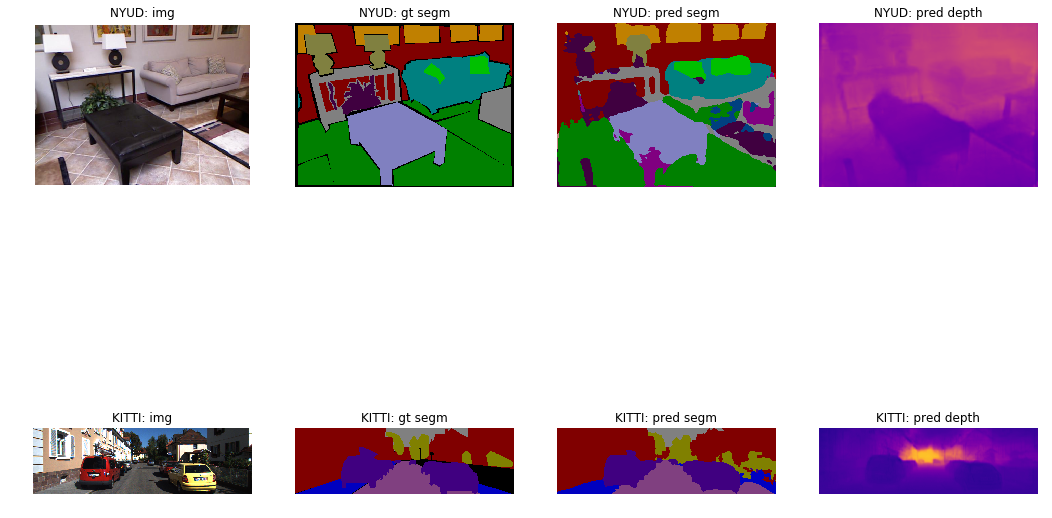

In [10]:
with torch.no_grad():
    # nyud
    img_var = Variable(torch.from_numpy(prepare_img(img_nyud).transpose(2, 0, 1)[None]), requires_grad=False).float()
    if HAS_CUDA:
        img_var = img_var.cuda()
    segm, depth = model(img_var)
    segm = cv2.resize(segm[0, :(NUM_CLASSES_NYUD)].cpu().data.numpy().transpose(1, 2, 0),
                      img_nyud.shape[:2][::-1],
                      interpolation=cv2.INTER_CUBIC)
    depth = cv2.resize(depth[0, 0].cpu().data.numpy(),
                       img_nyud.shape[:2][::-1],
                       interpolation=cv2.INTER_CUBIC)
    segm_nyud = CMAP_NYUD[segm.argmax(axis=2) + 1].astype(np.uint8)
    depth_nyud = np.abs(depth)
    # kitti
    img_var = Variable(torch.from_numpy(prepare_img(img_kitti).transpose(2, 0, 1)[None]), requires_grad=False).float()
    if HAS_CUDA:
        img_var = img_var.cuda()
    segm, depth = model(img_var)
    segm = cv2.resize(segm[0, (NUM_CLASSES_NYUD):(NUM_CLASSES_NYUD + NUM_CLASSES_KITTI)].cpu().data.numpy().transpose(1, 2, 0),
                      img_kitti.shape[:2][::-1],
                      interpolation=cv2.INTER_CUBIC)
    depth = cv2.resize(depth[0, 0].cpu().data.numpy(),
                       img_kitti.shape[:2][::-1],
                       interpolation=cv2.INTER_CUBIC)
    segm_kitti = CMAP_KITTI[segm.argmax(axis=2)].astype(np.uint8)
    depth_kitti = np.abs(depth)

plt.figure(figsize=(18, 12))
plt.subplot(241)
plt.imshow(img_nyud)
plt.title('NYUD: img')
plt.axis('off')
plt.subplot(242)
plt.imshow(CMAP_NYUD[gt_segm_nyud + 1])
plt.title('NYUD: gt segm')
plt.axis('off')
plt.subplot(243)
plt.imshow(segm_nyud)
plt.title('NYUD: pred segm')
plt.axis('off')
plt.subplot(244)
plt.imshow(depth_nyud, cmap='plasma', vmin=MIN_DEPTH_NYUD, vmax=MAX_DEPTH_NYUD)
plt.title('NYUD: pred depth')
plt.axis('off')
plt.subplot(245)
plt.imshow(img_kitti)
plt.title('KITTI: img')
plt.axis('off')
plt.subplot(246)
plt.imshow(gt_segm_kitti)
plt.title('KITTI: gt segm')
plt.axis('off')
plt.subplot(247)
plt.imshow(segm_kitti)
plt.title('KITTI: pred segm')
plt.axis('off')
plt.subplot(248)
plt.imshow(depth_kitti, cmap='plasma', vmin=MIN_DEPTH_KITTI, vmax=MAX_DEPTH_KITTI)
plt.title('KITTI: pred depth')
plt.axis('off');